In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

walker_60_suwon = pd.read_csv("D:\\jupyter_proj\\walker_60_suwon.csv")

In [2]:
Q1 = walker_60_suwon['도로심각도지수basic'].quantile(.25)
Q3 = walker_60_suwon['도로심각도지수basic'].quantile(.75)
Q2 = walker_60_suwon['도로심각도지수basic'].quantile(.5)
Q4 = walker_60_suwon['도로심각도지수basic'].quantile(1)

print("Q1 =",Q1)
print("Q2 =",Q2)
print("Q3 =",Q3)
print("Q4 =",Q4)

Q1 = 0.0068
Q2 = 0.1168
Q3 = 0.1168
Q4 = 1.0068


In [3]:
for i in range(len(walker_60_suwon)):
    if walker_60_suwon['도로심각도지수basic'][i] <= 0.0068:
        walker_60_suwon['도로심각도지수basic'][i] = '하'
    elif walker_60_suwon['도로심각도지수basic'][i] <= 0.1168:
        walker_60_suwon['도로심각도지수basic'][i] = '중'
    else:
        walker_60_suwon['도로심각도지수basic'][i] = '상'

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:

In [4]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in walker_60_suwon.columns:
    if walker_60_suwon[column_name].dtype == object:
        walker_60_suwon[column_name] = le.fit_transform(walker_60_suwon[column_name])
    else:
        pass

In [5]:
le.classes_

array(['상', '중', '하'], dtype=object)

In [67]:
np.random.seed(100)

xval = walker_60_suwon[walker_60_suwon.columns.difference(['도로심각도지수basic'])]
yval = walker_60_suwon['도로심각도지수basic']

x_train, x_test, y_train, y_test = train_test_split(xval, yval, train_size=0.7, random_state=97)
pipeline = Pipeline([('clf', RandomForestClassifier(criterion='gini', class_weight = 'balanced_subsample'))])

In [68]:
parameters = {
    'clf__n_estimators':(1000,1500, 2000, 2500, 3000, 3500),
    'clf__max_depth':(5,10, 15, 20, 30),
    'clf__min_samples_split':(2,3),
    'clf__min_samples_leaf':(1,2)
}

In [71]:
x_train = x_train.drop('Unnamed: 0', axis=1)

In [72]:
x_test = x_test.drop('Unnamed: 0', axis=1)

In [75]:
x_test.columns

Index(['가해자성별', '교차로형태', '기상상태', '노면상태', '노면상태_대분류', '노인보호구역', '당사자종별가해자',
       '당사자종별피해자', '도로선형', '도로선형_대분류', '도로선형_중분류', '도로종류', '도로형태', '법규위반가해자',
       '보호장구가해자_대분류', '보호장구피해자_대분류', '사고유형', '사고유형_대분류', '어린이보호구역', '연령가해자',
       '연령피해자', '요일', '주야', '차량용도가해자', '차량용도가해자_대분류', '차량용도피해자', '차량용도피해자_대분류',
       '피해자성별', '행동유형가해자', '행동유형피해자', '행동유형피해자_대분류'],
      dtype='object')

In [76]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=5, verbose=1, scoring='accuracy')
grid_search.fit(x_train, y_train)

np.random.seed(100)

print('Best Training score : %0.3f' %grid_search.best_score_)
print('Best parameter set:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t%s: %r' %(param_name, best_parameters[param_name]))

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 27.7min finished


Best Training score : 0.540
Best parameter set:
	clf__max_depth: 10
	clf__min_samples_leaf: 2
	clf__min_samples_split: 2
	clf__n_estimators: 3000


In [77]:
from sklearn.metrics import accuracy_score, classification_report

predictions = grid_search.predict(x_test)

print("Testing accuracy:", round(accuracy_score(y_test, predictions),4))
print("\nComplete report of Testing data\n", classification_report(y_test, predictions))

Testing accuracy: 0.54

Complete report of Testing data
               precision    recall  f1-score   support

           0       0.17      0.04      0.06        26
           1       0.60      0.57      0.58       237
           2       0.48      0.58      0.53       174

    accuracy                           0.54       437
   macro avg       0.42      0.39      0.39       437
weighted avg       0.53      0.54      0.53       437



In [78]:
print('\n\nRandom Forest Grid Search- Test Confusion Matrix\n\n', pd.crosstab(y_test, predictions, rownames=["Actuall"],colnames=["Predicted"]))



Random Forest Grid Search- Test Confusion Matrix

 Predicted  0    1    2
Actuall               
0          1   16    9
1          4  134   99
2          1   72  101


In [41]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,predictions)

array([[  3,  15,   8],
       [ 22, 113, 102],
       [ 12,  59, 103]], dtype=int64)


Feature ranking:

Feature 19 , 연령가해자 0.1348
Feature 20 , 연령피해자 0.1221
Feature 29 , 행동유형피해자 0.0807
Feature 21 , 요일 0.0659
Feature 6 , 당사자종별가해자 0.0612
Feature 23 , 차량용도가해자 0.0596
Feature 28 , 행동유형가해자 0.0524
Feature 16 , 사고유형 0.0431
Feature 17 , 사고유형_대분류 0.0429
Feature 12 , 도로형태 0.0381
Feature 11 , 도로종류 0.0366
Feature 13 , 법규위반가해자 0.0314
Feature 0 , 가해자성별 0.0313
Feature 1 , 교차로형태 0.03
Feature 24 , 차량용도가해자_대분류 0.0288
Feature 27 , 피해자성별 0.0287
Feature 14 , 보호장구가해자_대분류 0.0261
Feature 22 , 주야 0.0221
Feature 8 , 도로선형 0.0154
Feature 2 , 기상상태 0.0148
Feature 3 , 노면상태 0.0095
Feature 4 , 노면상태_대분류 0.009
Feature 9 , 도로선형_대분류 0.0078
Feature 10 , 도로선형_중분류 0.0076
Feature 5 , 노인보호구역 0.0
Feature 30 , 행동유형피해자_대분류 0.0
Feature 7 , 당사자종별피해자 0.0
Feature 18 , 어린이보호구역 0.0
Feature 25 , 차량용도피해자 0.0
Feature 26 , 차량용도피해자_대분류 0.0
Feature 15 , 보호장구피해자_대분류 0.0


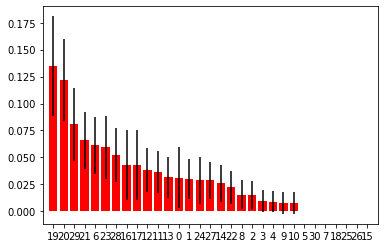

In [79]:
import matplotlib.pyplot as plt

rf_fit = RandomForestClassifier(n_estimators=3000, criterion='gini', max_depth=10, min_samples_split=2, min_samples_leaf=2)
rf_fit.fit(x_train, y_train)

importances = rf_fit.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_fit.estimators_], axis=0)

indices = np.argsort(importances)[::-1]

colnames = list(x_train.columns)

print("\nFeature ranking:\n")

for f in range(x_train.shape[1]):
    print("Feature", indices[f], ",", colnames[indices[f]], round(importances [indices[f]],4))
    
plt.figure()
plt.bar(range(x_train.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()